Formation Data Analyst avec OpenClassrooms




Projet 9 : Produisez une étude de marché avec R ou Python




Ainouni Anwar


In [1]:
!python --version

Python 3.9.12


# Préambule

Dans ce projet, je prends le rôle d'un data analyst qui travaille chez "La poule qui chante", une entreprise française d’agroalimentaire qui souhaite se développer à l'international.

Mon objectif sera de proposer une première analyse des groupements de pays que l’on peut cibler pour exporter les poulets.
Pour la partie analyse, je vais tester la classification ascendante hiérarchique, avec un dendrogramme comme visualisation. Ensuite tester la méthode des k-means pour comparer les résultats des deux méthodes de clustering. 

Pour finir, je vais  réaliser une ACP afin de visualiser les résultats, comprendre les groupes, les liens entre les variables, les liens entre les individus.

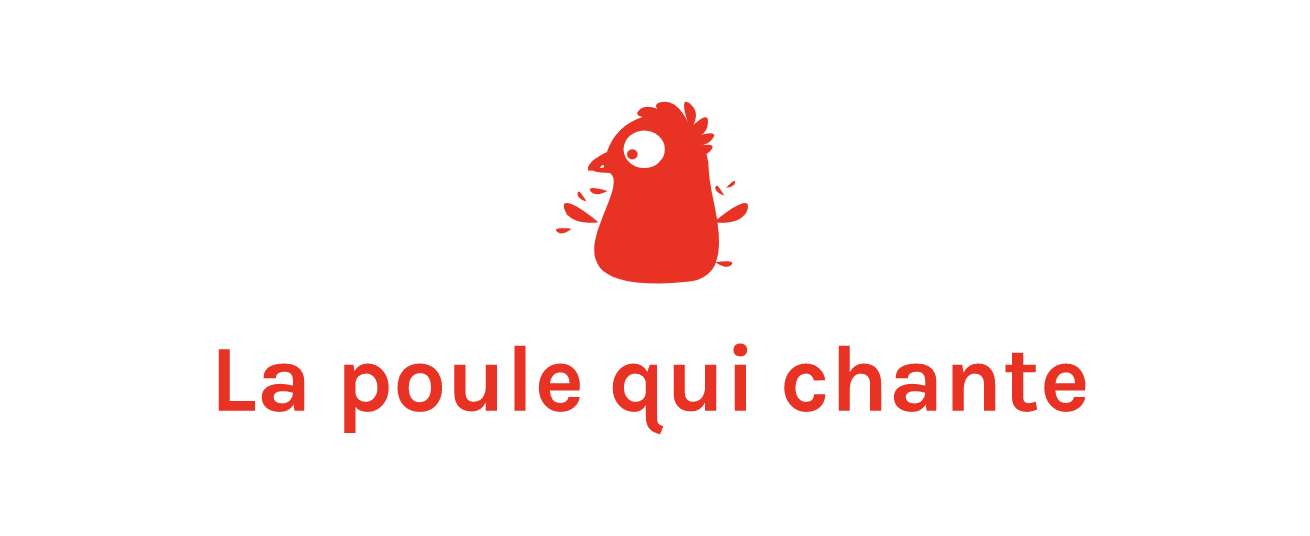

In [2]:
# Importations des librairies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Préparation des données

## Importation des données

In [3]:
pop = pd.read_csv('Population_2000_2018.csv')
dispo = pd.read_csv('DisponibiliteAlimentaire_2017.csv')
Facil_index = pd.read_csv('Score_aff.csv')

### Données Population_2000_2018

In [4]:
pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4411 entries, 0 to 4410
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Code Domaine            4411 non-null   object 
 1   Domaine                 4411 non-null   object 
 2   Code zone               4411 non-null   int64  
 3   Zone                    4411 non-null   object 
 4   Code Élément            4411 non-null   int64  
 5   Élément                 4411 non-null   object 
 6   Code Produit            4411 non-null   int64  
 7   Produit                 4411 non-null   object 
 8   Code année              4411 non-null   int64  
 9   Année                   4411 non-null   int64  
 10  Unité                   4411 non-null   object 
 11  Valeur                  4411 non-null   float64
 12  Symbole                 4411 non-null   object 
 13  Description du Symbole  4411 non-null   object 
 14  Note                    258 non-null    

In [5]:
# Vérifier la présence des doublons
pop.duplicated().sum() 

0

- Ajouter une colonne des taux de croissance démographique entre  2012 et 2017

In [6]:
population=pop.pivot_table(index = 'Zone', columns = 'Année', values = 'Valeur')

In [7]:
population['evo_demo_2012_2017(%)']=((population[2017]-population[2012]) /(population[2017]))*100

In [8]:
# selectionner les colonnes qu'on veut utiliser
df_population=population.loc[:,['evo_demo_2012_2017(%)',2017]]

In [9]:
df_population.rename(columns = {2017:'Nbr pop'}, inplace = True)

In [10]:
df_population['Nbr pop'].describe()

count    2.360000e+02
mean     3.198362e+04
std      1.318949e+05
min      7.930000e-01
25%      3.803032e+02
50%      5.203511e+03
75%      1.930842e+04
max      1.421022e+06
Name: Nbr pop, dtype: float64

### Données DisponibiliteAlimentaire_2017

In [11]:
dispo.head()

,Code Domaine,Domaine,Code zone,Zone,Code Élément,Élément,Code Produit,Produit,Code année,Année,Unité,Valeur,Symbole,Description du Symbole
0,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5511,Production,2511,Blé et produits,2017,2017,Milliers de tonnes,4281.0,S,Données standardisées
1,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5611,Importations - Quantité,2511,Blé et produits,2017,2017,Milliers de tonnes,2302.0,S,Données standardisées
2,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5072,Variation de stock,2511,Blé et produits,2017,2017,Milliers de tonnes,-119.0,S,Données standardisées
3,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5911,Exportations - Quantité,2511,Blé et produits,2017,2017,Milliers de tonnes,0.0,S,Données standardisées
4,FBS,Nouveaux Bilans Alimentaire,2,Afghanistan,5301,Disponibilité intérieure,2511,Blé et produits,2017,2017,Milliers de tonnes,6701.0,S,Données standardisées


In [12]:
# selectionner les colonnes qu'on veut utiliser
dispo_1=dispo.loc[:,['Zone','Élément','Produit','Valeur']]

In [13]:
# selectionner les données de la viande volailles
dispo_2 = dispo_1.loc[dispo_1['Produit']==  'Viande de Volailles']


In [14]:
dispo_2.dtypes

Zone        object
Élément     object
Produit     object
Valeur     float64
dtype: object

In [15]:
# traitement de nos données sur la viandes volailles
dispo_3=dispo_2.pivot_table(index='Zone', columns='Élément', values = 'Valeur').fillna('0')
dispo_3['Nourriture'] = dispo_3['Nourriture'].astype(float)
dispo_3['Importations - Quantité'] = dispo_3['Importations - Quantité'].astype(float)
dispo_3['Disponibilité intérieure'] = dispo_3['Disponibilité intérieure'].astype(float)

In [16]:
# selectinner les données sur la nourriture
dispo_1 = dispo.loc[:,['Zone','Élément','Produit','Valeur']]
dispo_4 = dispo_1.loc[dispo_1['Élément']==  'Nourriture']


In [17]:
# calcul de disponibilité en nourriture par pays
dispo_5=dispo_4.groupby('Zone',as_index= False)[ 'Valeur'].sum() 
dispo_5.rename(columns = {'Valeur':'Nourriture en tonnes'}, inplace = True)


In [18]:
# ajout de nouveaux colonnes dans la tables disponibilités alimentaire
dispo_6 = pd.merge(dispo_5, dispo_3, on='Zone')
dispo_6['Variation de stock'] = dispo_6['Variation de stock'].astype(float)
dispo_6['Production'] = dispo_6['Production'].astype(float)
dispo_6['production/nourriture (%)']=(dispo_6['Production']/(dispo_6['Nourriture']))*100
dispo_6['nourrVolaille/nourritTotal (%)']=(dispo_6['Nourriture']/dispo_6['Nourriture en tonnes'])*100

In [19]:
# je selectionne les colonnes que je vais utilisé
dispo_7=dispo_6.loc[:,['Zone','Importations - Quantité','production/nourriture (%)','nourrVolaille/nourritTotal (%)']]

In [20]:
dispo_7.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172 entries, 0 to 171
Data columns (total 4 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Zone                            172 non-null    object 
 1   Importations - Quantité         172 non-null    float64
 2   production/nourriture (%)       170 non-null    float64
 3   nourrVolaille/nourritTotal (%)  172 non-null    float64
dtypes: float64(3), object(1)
memory usage: 6.7+ KB


### Données score de la facilité de faire des affaires

[Source des données](https://archive.doingbusiness.org/fr/data/doing-business-score#:~:text=Le%20score%20de%20la%20facilit%C3%A9%20de%20faire%20des%20affaires%20d,100%20repr%C3%A9sente%20la%20meilleure%20performance) 

Le score de la facilité de faire des affaires aide à évaluer le niveau absolu de la performance réglementaire au cours du temps. Le score recense l’écart de chaque économie par rapport à la meilleure performance réglementaire pour chaque indicateur, à travers toutes les économies couvertes par Doing Business depuis 2005. L’écart entre la performance d’une économie et la meilleure performance, ainsi que le changement absolu de l’environnement réglementaire de chaque économie, tels que mesurés par Doing Business, peuvent être observés à tout moment. Le score de la facilité de faire des affaires d’une économie est calculée sur une échelle de 0 à 100, où 0 représente la performance la plus basse et 100 représente la meilleure performance.

Remarque : j'ai utilisé des données de l'année 2019 estimant qu'entre l'année 2017 et 2019 le score n'a pas évolué

In [21]:
Facil_index.head()

,Zone,SFFA
0,Afghanistan,44.2
1,Afrique du Sud,66.7
2,Albanie,67.0
3,Algérie,48.5
4,Allemagne,79.3


In [22]:
Facil_index.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Zone    214 non-null    object 
 1   SFFA    214 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.5+ KB


## Tableau final des données 

Je réalise mes jointures entre mes tables

In [23]:
final = pd.merge(dispo_7, df_population, on='Zone', indicator=True)



Vérifions que la colonne _merge ne contienne que les valeurs "both" :

In [24]:
final._merge.value_counts()

both          172
left_only       0
right_only      0
Name: _merge, dtype: int64

In [25]:
final.drop(['_merge'], axis = 1, inplace=True)

In [26]:
final_1=pd.merge(final, Facil_index, on='Zone',indicator=True)


In [27]:
final_1._merge.value_counts()

both          163
left_only       0
right_only      0
Name: _merge, dtype: int64

In [28]:
final_1.drop(['_merge'], axis = 1, inplace=True)

In [29]:
final_1=final_1.fillna(0)

Ma table final :

In [30]:
display(final_1.head(5))

,Zone,Importations - Quantité,production/nourriture (%),nourrVolaille/nourritTotal (%),evo_demo_2012_2017(%),Nbr pop,SFFA
0,Afghanistan,29.0,50.909091,0.424121,14.146796,36296.113,44.2
1,Afrique du Sud,514.0,81.916462,6.414297,7.326988,57009.756,66.7
2,Albanie,38.0,27.659574,1.294409,-1.037630,2884.169,67.0
3,Algérie,2.0,104.166667,0.798645,9.677150,41389.189,48.5
4,Allemagne,842.0,94.095712,2.063138,2.039455,82658.409,79.3


J'exporte ma table pour la suite de l'analyse

In [31]:
final_1.to_csv('bilan.csv', index=False)


# Exploration des données

## Corrélation entre les dimensions

In [32]:
#Correlationmatrix
final_1.corr()

,Importations - Quantité,production/nourriture (%),nourrVolaille/nourritTotal (%),evo_demo_2012_2017(%),Nbr pop,SFFA
Importations - Quantité,1.000000,0.028790,0.148691,-0.123269,0.147392,0.299312
production/nourriture (%),0.028790,1.000000,-0.105484,-0.262096,0.117912,0.290730
nourrVolaille/nourritTotal (%),0.148691,-0.105484,1.000000,-0.224667,-0.108403,0.141900
evo_demo_2012_2017(%),-0.123269,-0.262096,-0.224667,1.000000,-0.038214,-0.529187
Nbr pop,0.147392,0.117912,-0.108403,-0.038214,1.000000,0.077823
SFFA,0.299312,0.290730,0.141900,-0.529187,0.077823,1.000000


Affichage graphique :

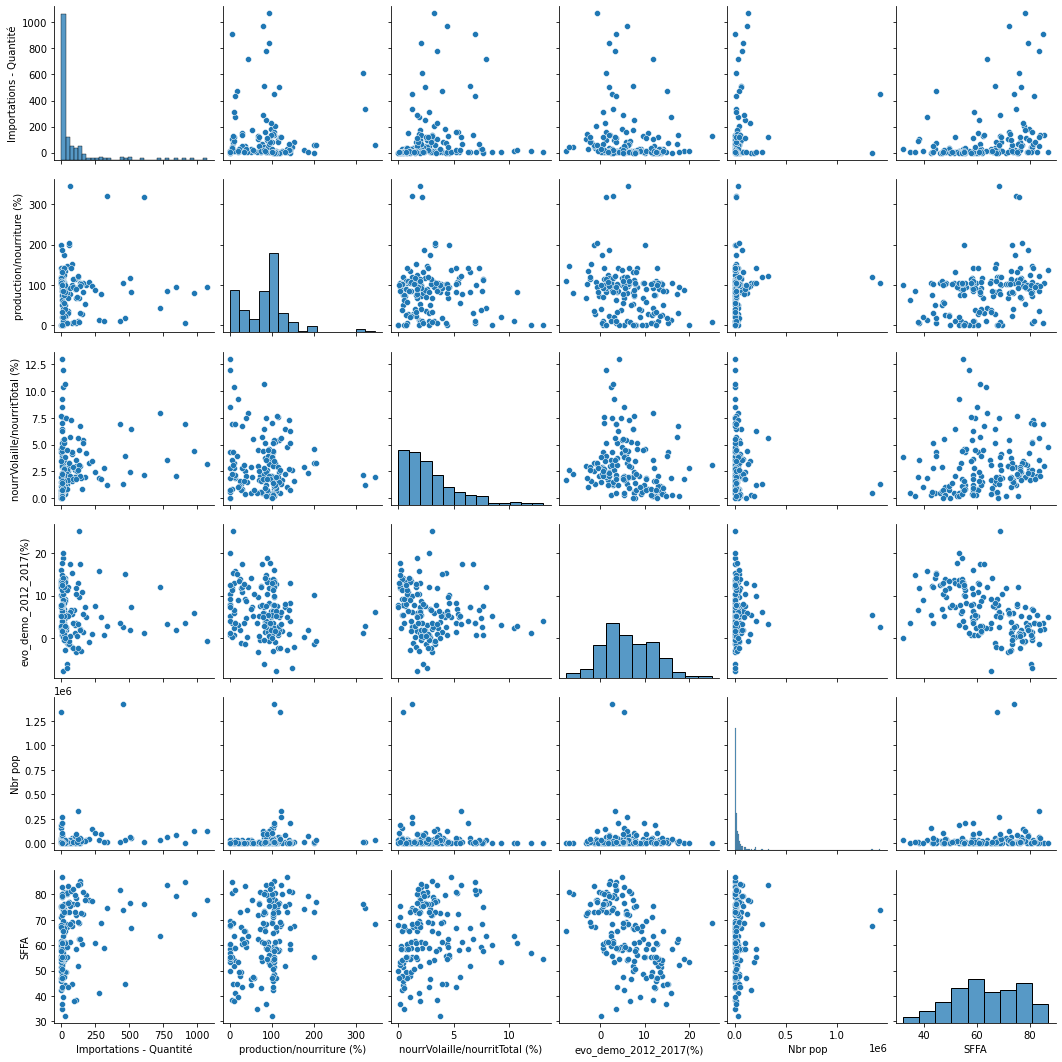

In [33]:

sns.pairplot(final_1)

Text(0.5, 1.0, 'Matrice de corrélation')

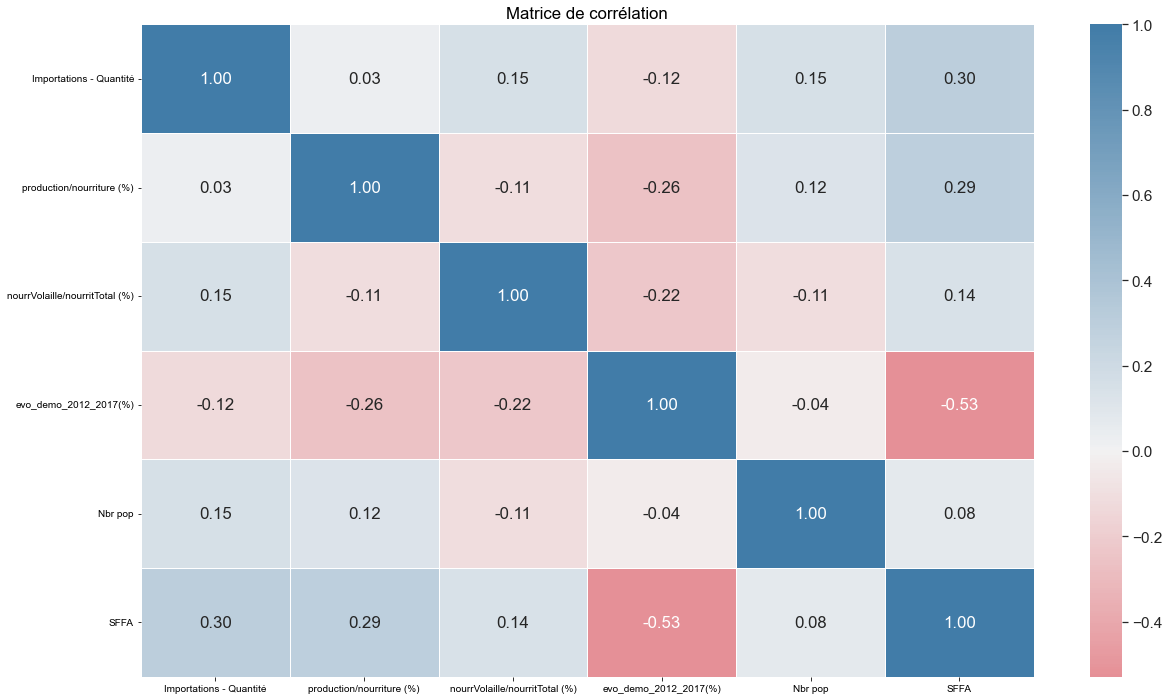

In [34]:
# Visualizingthecorrelationmatrix
cmap = sns.diverging_palette(h_neg=10,                              
                             h_pos=240,                            
                             as_cmap=True)
fig, ax = plt.subplots(figsize=(20, 12))
sns.set(font_scale=1.4)
sns.heatmap(final_1.corr(), center=0,             
                                                      cmap=cmap, linewidths=1,             
                                                      annot=True, fmt=".2f")
plt.title('Matrice de corrélation')


Observations:

On peut déjà commencer à observer la corrélation entre nos variables.
on peut observer des corrélations positives entre :

    le score de la facilité à faire des affaires et le ratio production/nourriture
    le score de la facilité à faire des affaires et l'importation
on peut obsever des corrélations negatives entre :

     le score de la faciloté à faire des affaires et la croissance démographique
     le ratio production/nourriture et la croissance démographique
     le ratio nourrtture vollaille/nourriture totale
    




## Distribution des dimensions

Affichage graphique :

<AxesSubplot:ylabel='nourrVolaille/nourritTotal (%)'>

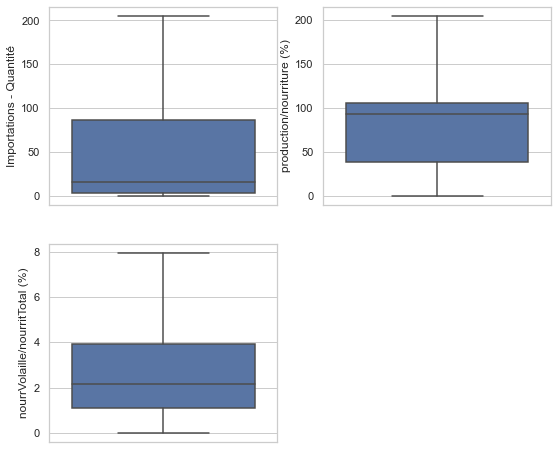

In [35]:
# Afficher des boxplot
plt.figure(figsize=(9, 8))
sns.set(style="whitegrid")
plt.subplot(221)
sns.boxplot(data=final_1,y='Importations - Quantité', showfliers = False)
plt.subplot(222)
sns.boxplot(data=final_1, y='production/nourriture (%)', showfliers = False)
plt.subplot(223)
sns.boxplot(data=final_1, y='nourrVolaille/nourritTotal (%)', showfliers = False)

# plt.savefig('Distribution de l\'ensemble variables.jpg')

<AxesSubplot:ylabel='evo_demo_2012_2017(%)'>

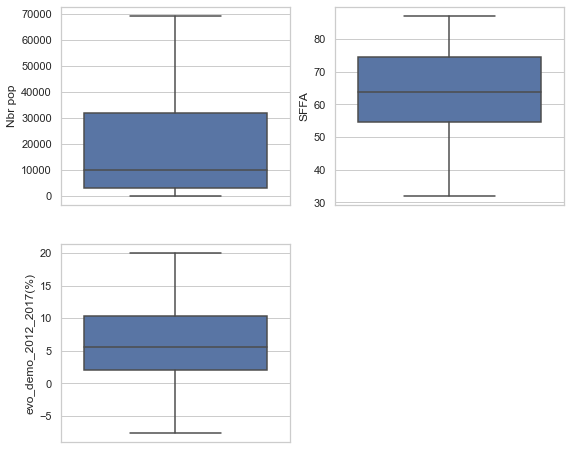

In [36]:
plt.figure(figsize=(9, 8))
plt.subplot(221)
sns.boxplot(data=final_1, y='Nbr pop', showfliers = False)
plt.subplot(222)
sns.boxplot(data=final_1, y='SFFA', showfliers = False)
plt.subplot(223)
sns.boxplot(data=final_1,y='evo_demo_2012_2017(%)', showfliers = False)


Observations:

La variation des valeurs et la présence d'outliers sont principalement dues à la différence de nombre de population entre les pays.